## Описание проекта

Нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

### Инструкция по выполнению проекта

1. Загрузите данные и выполните их ресемплирование по одному часу.
2. Проанализируйте данные.
3. Обучите разные модели с различными гиперпараметрами. Сделайте тестовую выборку размером 10% от исходных данных.
4. Проверьте данные на тестовой выборке и сделайте выводы.


# 1. Подготовка

In [1]:
#импортируем библиотеки
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error
from fbprophet import Prophet

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
import matplotlib.pyplot as plt

from scipy import stats
import statsmodels.api as sm

import holidays
import itertools

In [2]:
from pandas.plotting import register_matplotlib_converters       

register_matplotlib_converters()       

In [3]:
#зугрузим датасет
df = pd.read_csv('/home/andrey/Datasets/taxi.csv',index_col=[0], parse_dates=[0])
df.sort_index(inplace=True)
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [4]:
#сделаем ресемплинг по часу
df = df.resample('1H').sum()
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


# 2. Анализ

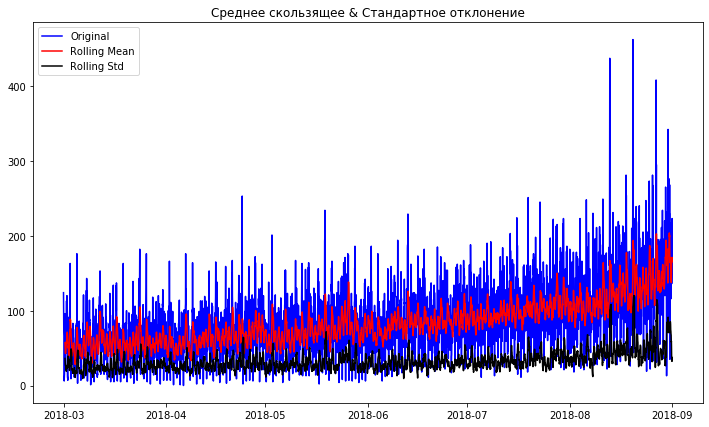

In [5]:
#Проверим ряд на стационарность

rolling_mean = df.rolling(window = 12).mean()
rolling_std = df.rolling(window = 12).std()

plt.figure(figsize=(12, 7))
plt.plot(df, color = 'blue', label = 'Original')
plt.plot(rolling_mean, color = 'red', label = 'Rolling Mean')
plt.plot(rolling_std, color = 'black', label = 'Rolling Std')
plt.legend(loc = 'best')
plt.title('Среднее скользящее & Стандартное отклонение')
plt.show()

Видно что скользящее среднее и стандартное отклонение увелививаются со временем, исходя их этого можно сделать вывод, что ряд не стационарный

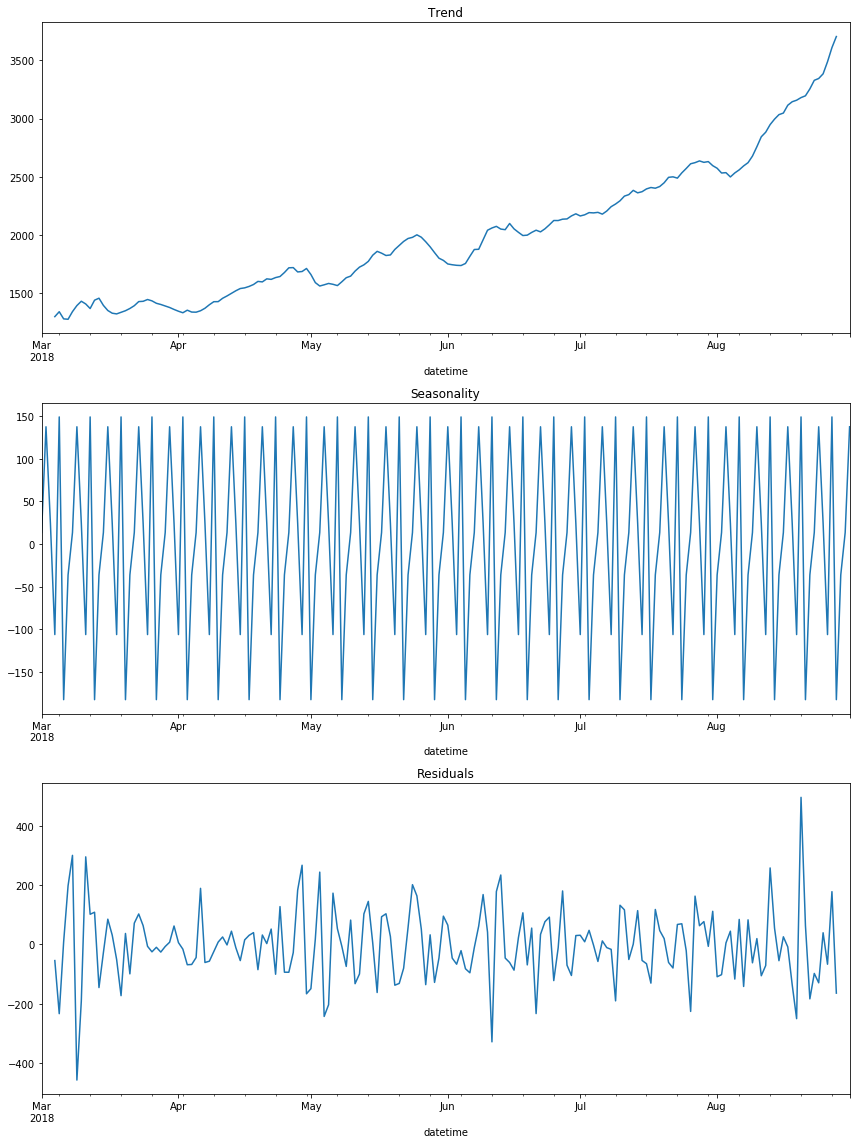

In [6]:
#Посмотрим на тренды и сезонность временного ряда
decomposed = seasonal_decompose(df.resample('1D').sum())

plt.figure(figsize=(12, 16))
plt.subplot(311)

decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)

decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)

decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

Однозначно виден общий тренд к росту числа заказов заказов. Сезонность посмотрим за 2 недели августа

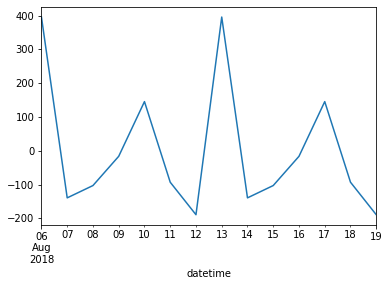

In [7]:
#Сезонность подробнее посмотрим за 2 недели августа
two_month_seas = df['2018-08-06':'2018-08-19'].resample('1D').sum()

decomposed = seasonal_decompose(two_month_seas)

decomposed.seasonal.plot(ax=plt.gca())

Максимальное количество заказов приходится на понедельники и пятницу. меньше всего заказов такси в воскресенье

In [15]:
#создадим признаки

def make_features(df, max_lag, rolling_mean_size):
    df_features = df.copy()
    df_features['month'] = df.index.month
    df_features['day'] = df.index.day
    df_features['dayofweek'] = df.index.dayofweek
    df_features['is_mon_fr'] = df.index.dayofweek.isin([1,5])*1
    df_features['hour'] = df.index.hour
    df_features['is_weekend'] = df.index.dayofweek.isin([5,6])*1
    df_features['is_morning'] = df.index.hour.isin(range(5,11))*1
    
    for lag in range(1, max_lag + 1):
        df_features['lag_{}'.format(lag)] = df['num_orders'].shift(lag)

    df_features['rolling_mean'] = df['num_orders'].shift().rolling(rolling_mean_size).mean()
    
    return(df_features)

# 3. Обучение

In [23]:
#обучим модель линейной регрессии

for i in range(5,35,5):
    for j in range(1, 3):
        df_features = make_features(df, i, j)
        
        train, test = train_test_split(df_features, shuffle=False, test_size=0.1)
        train = train.dropna()
        test = test.dropna()

        y_train = train['num_orders']
        X_train = train.drop('num_orders', axis = 1)

        y_test = test['num_orders']
        X_test = test.drop('num_orders', axis = 1)
        
        #обучим модель линейной регрессии 

        model = LinearRegression()
        model.fit(X_train, y_train)
        predict = model.predict(X_test)
        
        rmse = round(mean_squared_error(y_test, predict))**0.5
        print("RMSE", rmse, 'lag' , i, 'rolling mean', j)

RMSE 52.55473337388365 lag 5 rolling mean 1
RMSE 52.55473337388365 lag 5 rolling mean 2
RMSE 50.11985634456667 lag 10 rolling mean 1
RMSE 50.12983143797713 lag 10 rolling mean 2
RMSE 50.556898639058154 lag 15 rolling mean 1
RMSE 50.73460357586329 lag 15 rolling mean 2
RMSE 51.07837115648854 lag 20 rolling mean 1
RMSE 51.45872132107443 lag 20 rolling mean 2
RMSE 44.68780594300866 lag 25 rolling mean 1
RMSE 44.67661580737735 lag 25 rolling mean 2
RMSE 45.60701700396552 lag 30 rolling mean 1
RMSE 45.749316934791494 lag 30 rolling mean 2


Лучшее RMSE у модели линейной регресси 44.67661580737735 с лагом в 25

Предскажем временной ряд с помощью fbprophet

In [26]:
#добавим праздничные дни 2018 года.
holiday = pd.DataFrame([])
for date, name in sorted(holidays.Russia(years=[2018]).items()):
    holiday = holiday.append(pd.DataFrame({'ds': date, 'holiday': "RUS-Holidays"}, index=[0]), ignore_index=True)
holiday['ds'] = pd.to_datetime(holiday['ds'], format='%Y-%m-%d', errors='ignore')

In [27]:
#обучим модель с помощью Facebook Prophet
m = Prophet(weekly_seasonality = True,
            holidays=holiday,
           daily_seasonality = True,
           n_changepoints = 50)
X = pd.DataFrame({ 'ds': train.index.values, 'y': train['num_orders']})

m.fit(X)
future = m.make_future_dataframe(periods = len(y_test))
forecast = m.predict(future)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


In [28]:
forecast = forecast['yhat'].tail(442)

In [29]:
(mean_squared_error(y_test, forecast))**0.5

115.91833429823453

facebook prophet показал худший резултьтат.

# 4. Тестирование

In [30]:
#проверим модель регрессии с лучшими параметрами.

df_features = make_features(df, 25, 2)
train, test = train_test_split(df_features, shuffle=False, test_size=0.1)
train = train.dropna()
test = test.dropna()

y_train = train['num_orders']
X_train = train.drop('num_orders', axis = 1)

y_test = test['num_orders']
X_test = test.drop('num_orders', axis = 1)
        
#обучим модель линейной регрессии 

model = LinearRegression()
model.fit(X_train, y_train)
predict = model.predict(X_test)
        
rmse = round(mean_squared_error(y_test, predict))**0.5
print(rmse)

44.67661580737735


Лучший показатель метрики RMSE удалось получить с помощью линейной регрессии с лагом в 25 и скользящим средним в 4